In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [30]:
directory = "covariance_results//"
names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "C1", "C2","Berea",
         "Isotropic12", "Isotropic13", "Isotropic14", "Anisotropic121214", "Anisotropic131314",
         "beadpack", "ketton","bentheimer", "estaillades", "doddington"]

In [31]:
class Porestats(object):
    def __init__(self, data):
        self.name = data["name"]
        
        self.porosity = data["porosity"]
        self.porosity_sq = self.porosity*self.porosity
        
        #Covariance: C(x) = cov(x)+Vv^2
        self.covariance_x = np.array(data["x"])
        self.covariance_y =  np.array(data["y"])
        self.covariance_z =  np.array(data["z"])
        
        self.covariance_averaged = np.array(data["averaged"])
        
        #Covariance Function: cov(x) = C(x)-Vv^2
        self.covariance_function_x = self.covariance_x-self.porosity_sq
        self.covariance_function_y = self.covariance_y-self.porosity_sq
        self.covariance_function_z = self.covariance_z-self.porosity_sq
        
        self.covariance_function_averaged = self.covariance_averaged-self.porosity_sq
        
        #Normalized Covariance Function: cov(x)/(Vv-Vv^2)
        self.normalized_covariance_x = np.divide(self.covariance_function_x, self.porosity-self.porosity_sq)
        self.normalized_covariance_y = np.divide(self.covariance_function_y, self.porosity-self.porosity_sq)
        self.normalized_covariance_z = np.divide(self.covariance_function_z, self.porosity-self.porosity_sq)
        
        self.normalized_covariance_averaged = np.divide(self.covariance_function_averaged, self.porosity-self.porosity_sq)
        
        self.fit_x = None
        self.fit_y = None
        self.fit_z = None
        
        self.fit_averaged = None
        
        self.poly_x = None
        self.poly_y = None
        self.poly_z = None
        
        self.poly_averaged = None
        
        self.fit_poly()
        
    def fit_poly(self, N=5):
        self.fit_x = np.polyfit(range(len(self.covariance_x[0:N])), self.covariance_x[0:N], 1)
        self.poly_x = np.poly1d(self.fit_x)
        
        self.fit_y = np.polyfit(range(len(self.covariance_y[0:N])), self.covariance_y[0:N], 1)
        self.poly_y = np.poly1d(self.fit_y)
        
        self.fit_z = np.polyfit(range(len(self.covariance_z[0:N])), self.covariance_z[0:N], 1)
        self.poly_z = np.poly1d(self.fit_z)
        
        self.fit_averaged = np.polyfit(range(len(self.covariance_averaged[0:N])), self.covariance_averaged[0:N], 1)
        self.poly_averaged = np.poly1d(self.fit_averaged)
        
        self.rc_x = (self.porosity_sq-self.porosity)/self.poly_x[1]
        self.rc_y = (self.porosity_sq-self.porosity)/self.poly_y[1]
        self.rc_z = (self.porosity_sq-self.porosity)/self.poly_z[1]
        
        self.rc_averaged = (self.porosity_sq-self.porosity)/self.poly_averaged[1]

In [32]:
covariance_results = {}

for file in os.listdir(directory):
        if file.endswith(".json"):
            with open(directory+file) as data_file:
                data = json.load(data_file)
                covariance_results[data["name"]] = Porestats(data)
                
resolution_file = "image_data/resolutions.json"
with open(resolution_file) as data_file:
    resolutions = json.load(data_file)

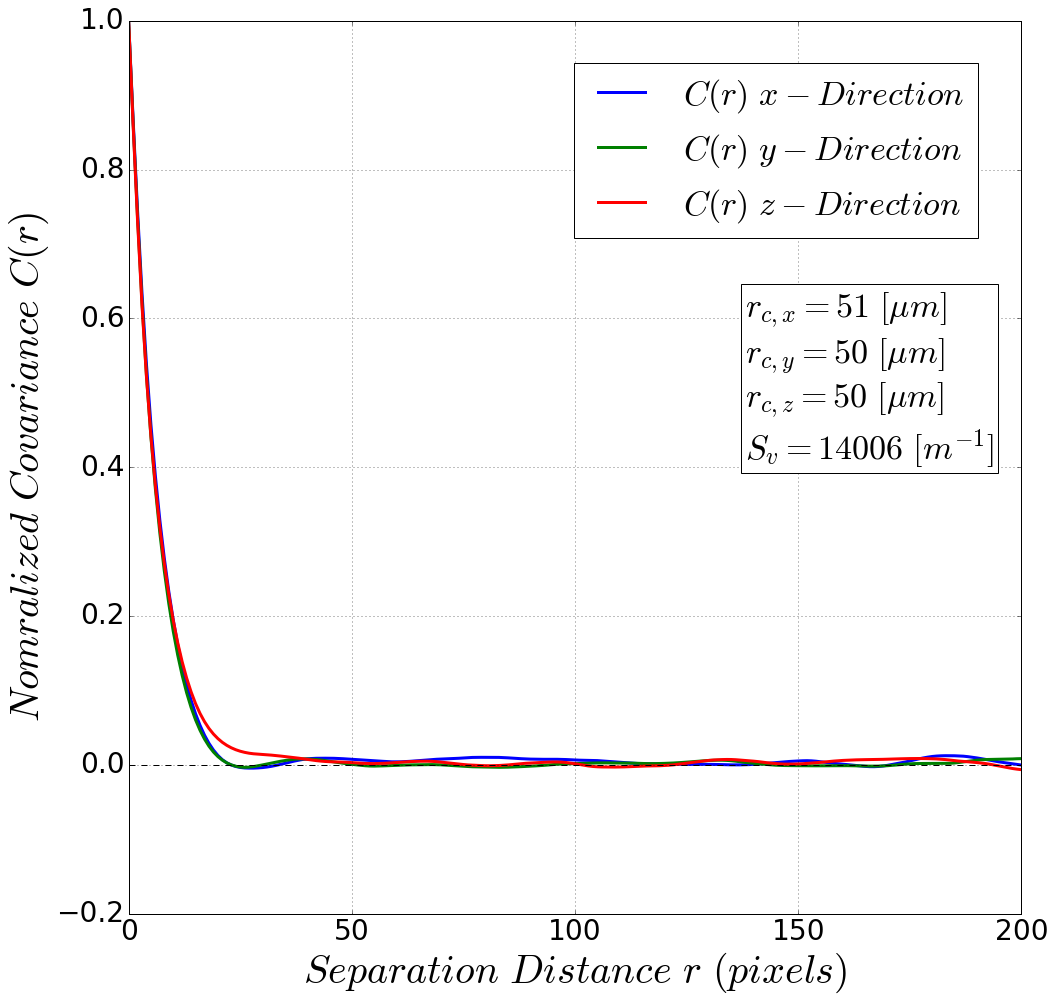

In [27]:
N = 200
for name in names:
    fig, ax = plt.subplots(1, 1, figsize=(16,16), sharey=False)
    pst = covariance_results[name]
  
    ax.set_ylabel(r'$Nomralized \ Covariance \ C(r)$', fontsize=40)

    ax.grid()
    ax.set_xlim(0, N)
    ax.set_ylim(-0.2, 1.0)

    ax.set_xlabel(r'$Separation \ Distance \ r \ (pixels)$', fontsize=40)

    ax.plot(range(len(pst.normalized_covariance_x)), pst.normalized_covariance_x, label=r'$C(r) \ x-Direction$', color="blue", alpha=1.0, linestyle="-", linewidth=3)
    ax.plot(range(len(pst.normalized_covariance_y)), pst.normalized_covariance_y, label=r'$C(r)\ y-Direction$', color="green", alpha=1.0, linestyle="-", linewidth=3)
    ax.plot(range(len(pst.normalized_covariance_z)), pst.normalized_covariance_z, label=r'$C(r) \ z-Direction$', color="red", alpha=1.0, linestyle="-", linewidth=3)
    ax.plot(range(len(pst.normalized_covariance_x)), [0.0]*len(pst.normalized_covariance_x), color="black", linestyle="--")
        
    Sv_cov = -4*pst.poly_averaged[1]*1./resolutions[name]

    rc_x_res = (pst.rc_x+1)*resolutions[name]*1e6
    rc_y_res = (pst.rc_y+1)*resolutions[name]*1e6
    rc_z_res = (pst.rc_z+1)*resolutions[name]*1e6
    
    textstr = '$r_{c,x}=%.0f \ [\mu m] \ \ \ \ $\n$r_{c, y}=%.0f \ [\mu m]$\n$r_{c, z}=%.0f \ [\mu m]$\n$S_{v}=%.0f \ [m^{-1}]\ \ $'%(rc_x_res,rc_y_res, rc_z_res,Sv_cov)
    
    props = dict(facecolor='white', alpha=1.0) #boxstyle='round', 

    # place a text box in upper left in axes coords
    if name in ["Isotropic12", "Isotropic13", "Isotropic14", "Anisotropic121214", "Anisotropic131314"]:
        text = ax.text(0.61, 0.95, textstr, transform=ax.transAxes, fontsize=34, verticalalignment='top', bbox=props)
    else:
        text = ax.text(0.69, 0.70, textstr, transform=ax.transAxes, fontsize=34, verticalalignment='top', bbox=props)
           
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels,  bbox_to_anchor=(0.65, 0.87, 0.32, .102), fontsize=34)
        frame = lgd.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')    

    for item in ax.get_xticklabels():
        item.set_fontsize(28)
    for item in ax.get_yticklabels():
        item.set_fontsize(28)
    plt.show()
    fig.savefig("covariance_results/covariance_appendix/covariance_"+name+".png", bbox_extra_artists=None, bbox_inches='tight', dpi=300)
    plt.close()

In [34]:
resolution_file = "image_data/resolutions.json"
with open(resolution_file) as data_file:
    resolutions = json.load(data_file)

In [39]:
for name in names:
    print name
    print covariance_results[name].porosity
    print covariance_results[name].rc_averaged*resolutions[name]*1e6
    print ""

S1
0.141302777778
81.0194160259

S2
0.246277
45.7267687742

S3
0.16857037037
54.0005140909

S4
0.171257518519
52.4106452101

S5
0.211309148148
66.7015156253

S6
0.239592888889
87.7319041919

S7
0.250482
56.8944901253

S8
0.339811740741
52.8379961196

S9
0.221745888889
52.2093826195

C1
0.23261375
37.0454573887

C2
0.168307671875
51.9822367775

Berea
0.19645303125
45.0842388429

Isotropic12
0.205047039972
147.855920463

Isotropic13
0.106092055855
47.2673317664

Isotropic14
0.0418220248111
37.6666440604

Anisotropic121214
0.146784904478
53.1972957948

Anisotropic131314
0.0827952578504
43.8056542008

beadpack
0.3625534
26.3591758021

ketton
0.129644743923
85.3037715162

bentheimer
0.201541984
55.4458496792

estaillades
0.121746374373
59.745171928

doddington
0.191665431411
63.8574123345

